In [219]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [220]:
import asammdf
Signal = asammdf.Signal
import numpy as np
import py
import get_files
import uuid
%matplotlib inline

In [221]:
%%file MDF2.py
import asammdf
def _path(self):
    return py.path.local(self._file.name)

def __repr__(self):
    return "MDF<{}, v={}>".format(self._path.basename, self.version)

# Dunctions to extend MDF with.
extend = {
    "__repr__": __repr__,
    "_path": property(_path),
}
MDF2 = type("MDF2", (asammdf.MDF, ), extend)

Overwriting MDF2.py


In [8]:
from MDF2 import MDF2

In [119]:
from signal_generators import *

In [120]:
import time

In [121]:
t0 = time.time()
T = np.zeros(0)

In [122]:
np.float32

numpy.float32

In [194]:
class SignalBuffer():
    def __init__(self, buffer_size=1024, dtype=np.double):
        self.buffer_size = buffer_size
        self.index=0
        self.uuid=uuid.uuid4()
        self.timestamps = np.ones(
            self.buffer_size,
            dtype=dtype,
        )*np.NaN
        self.samples = np.ones(
            self.buffer_size,
            dtype=dtype,
        )*np.NaN
        self.t0=None
        
    def append(self, timestamp, sample):           
        try:
            self.timestamps[self.index] = timestamp
            self.samples[self.index] = sample
            self.index+=1
        except:
            # TODO: Something
            raise
            
    def signal(self, name=None, unit=""):
        if name is None:
            name = self.uuid
        signal_ = asammdf.Signal(
            timestamps=self.timestamps[:self.index],
            samples=self.samples[:self.index],
            name=name,
            unit=unit,
            comment="buffer",
        )
        return signal_
    
    @property
    def _duration(self):
        return self.timestamps[self.index-1] - self.timestamps[0]
            
    @property
    def _free(self):
        return self.buffer_size-self.index
        
    def __repr__(self):
        return "SignalBuffer<free={}, {:.2}>".format(self._free, self._duration)

In [197]:
utc_buffer = SignalBuffer()
utc_buffer2 = SignalBuffer()

time_scale=10

t0 = time.time()
for _ in range(10):
    utc = time.time()
    utc_buffer.append(
        timestamp=(utc-t0)*time_scale,
        sample=utc,
    )
    time.sleep(1/time_scale)
    
for _ in range(10):
    utc = time.time()
    utc_buffer2.append(
        timestamp=(utc-t0)*time_scale,
        sample=utc,
    )
    time.sleep(1/time_scale)

In [199]:
f = utc_buffer.signal(name="UTC", unit="s").extend(utc_buffer2.signal())

In [200]:
import datetime

In [201]:
T = datetime.datetime.utcnow()

In [202]:
T.strftime("%Y%M%d")

'20183020'

In [203]:
T.strftime("%m-%B")

'02-February'

In [204]:
T.strftime("%Y%m%d-Testing")

'20180220-Testing'

In [205]:
import os
import py.path

In [206]:
channel_path_ = [
    "Data",
    T.strftime("%Y"),
    T.strftime("%m-%B"),
    T.strftime("%Y%m%d-Testing"),
]

channel_path = py.path.local(
        os.path.join(*channel_path_)
)

channel_path.dirpath().ensure(dir=True)

local('/projects/RaspberryMDF/DevNotebooks/Data/2018/02-February')

In [207]:
channel_path.exists()

False

In [208]:
signals = [
    utc_buffer.signal("Test"),
]

In [209]:
mdf = MDF2(
    version='4.11',
)
mdf.append(
    signals=signals,
    common_timebase=False,
)
o = mdf.save(
    dst=str(channel_path),
    overwrite=True,
    compression=2,
)

In [210]:
o

'/projects/RaspberryMDF/DevNotebooks/Data/2018/02-February/20180220-Testing.mf4'

In [211]:
mdf_ = MDF2(o)

In [212]:
Test = mdf_.get("Test")

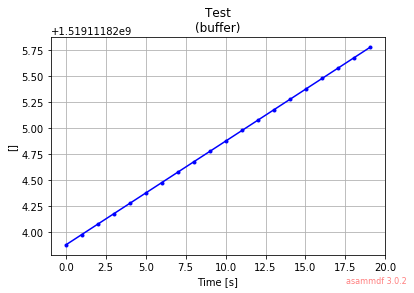

In [213]:
Test.extend(utc_buffer2.signal()).plot()

In [214]:
signals = [
        Test.extend(utc_buffer2.signal()),
]

In [215]:
mdf = MDF2(
    version='4.11',
)
mdf.append(
    signals=signals,
    common_timebase=False,
)
o = mdf.save(
    dst=o,
    overwrite=True,
    compression=2,
)

In [218]:
?mdf_.append